In [1]:
import os
os.chdir('D:/test/')

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from BSAPR_model_1 import *
import gzip
import os
import requests
from anndata import AnnData
import scanpy as sc

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(3141592)
np.random.seed(3141952)

# Data preprocessing

We demonstrate of the inference and prediction pipeline of BSAPR in this notebook using the Replogle perturbation dataset ([Replogle et al. 2022](https://www.cell.com/cell/pdf/S0092-8674(22)00597-9.pdf)) studied in [Bereket and Karaletsos, 2023](https://proceedings.neurips.cc/paper_files/paper/2023/file/0001ca33ba34ce0351e4612b744b3936-Paper-Conference.pdf). The prep-processed dataset can be downloaded from

In [ ]:
aws s3 cp --no-sign-request s3://insitro-research-2023-sams-vae/data/replogle.h5ad replogle.h5ad

# Gaussian BSAPR
We start from the BSAPR Gaussian model. We first load the data

In [5]:
# load the dataset

# log-transformed continuous response X
adata = sc.read_h5ad('replogle.h5ad')
adata.obs['n_feature'] = (adata.X > 0).sum(1)
my_observation = adata.X / adata.obs.core_scale_factor.values[:, None]
gene_name = list(adata.var.gene_name)
my_observation = torch.tensor(np.log(my_observation + 1.), dtype=torch.float)

# cell level information K
my_cell_info = adata.obs[['core_adjusted_UMI_count', 'mitopercent', 'n_feature', 'core_scale_factor']]
my_cell_info = torch.tensor(my_cell_info.to_numpy() * 1.0, dtype=torch.float)
my_cell_info[:, 2] = my_cell_info[:, 2] / my_cell_info[:, 0]
my_cell_info[:, 0] = np.log(my_cell_info[:, 0])

# annodated pathways
pathways = adata.uns['pathways']

# perturbation matrix C
my_conditioner = pd.get_dummies(adata.obs['gene'])
my_conditioner = my_conditioner.drop('non-targeting', axis=1)
cond_name = list(my_conditioner.columns)
my_conditioner = torch.tensor(my_conditioner.to_numpy() * 1.0, dtype=torch.float)

After having loaded the cell information matrix $\mathbf{K}$, perturbation information $\mathbf{C}$ and the pre-processed responses $\mathbf{X}$, we put them into the BSAPR training pipeline.

In [ ]:
# set size of NNs
start = time.time()
output_dim = my_observation.shape[1]
sample_size = my_observation.shape[0]
hidden_node = 1000
hidden_layer_1 = 4
hidden_layer_2 = 4
conditioner_dim = my_conditioner.shape[1]
cell_info_dim = my_cell_info.shape[1]
# set Gumble softmax hyperparameters
tau = torch.tensor(1.).to(device)
# creat the BSAPR model
parametric_model = BSAPR_Gaussian(conditioner_dim=conditioner_dim, output_dim=output_dim, base_dim=cell_info_dim,
                                  data_size=sample_size, hidden_node=hidden_node, hidden_layer_1=hidden_layer_1,
                                  hidden_layer_2=hidden_layer_2, tau=tau)
parametric_model = parametric_model.to(device)

parametric_model.BSAPR_train(epoch=300, observation=my_observation, cell_info=my_cell_info, perturbation=my_conditioner, 
                             nu_1=1.0, nu_2=0.1, nu_3=1.0, nu_4=0.1, nu_5=1.0, nu_6=0.1, 
                             lr=1e-3, device=device)

Given cell states $\mathbf{K}_i$ and perturbation effects $\mathbf{C}_i$ from test set, predicted basal states $\hat m_p(\mathbf{K}_i)$, perturbation effects $\hat \gamma_p(\mathbf{C}_i)$ and posterior inclusion probabilities $\hat \eta_p(\mathbf{K}_i)$ with their associated variances can be obtained by the following function calls.

In [ ]:
predicted_mu_mean, predicted_mu_var, predicted_gamma_mean, predicted_gamma_var, \
        logit_p, logit_p_log_var, predicted_base_mean = parametric_model(my_conditioner[parametric_model.test_id].to(device), my_cell_info[parametric_model.test_id].to(device))
estimated_base_mean = predicted_base_mean.detach().cpu().numpy()
estimated_perturbed_mean = (F.sigmoid(logit_p) * predicted_mu_mean).detach().cpu().numpy()
estimated_inclusion_prob = F.sigmoid(logit_p).detach().cpu().numpy()
estimated_perturbed_mean = (estimated_perturbed_mean + estimated_base_mean)
estimated_perturbed_var = logexpp1(parametric_model.base_log_var + (
            1.0 * (F.sigmoid(logit_p) > 0.5)) * predicted_gamma_mean).detach().cpu().numpy()

We visualise the averaged prediction vs averaged observation for each of the unique perturbations (i.e. average over all cells associated with a common perturbation). 

0
100
200
300
400
500
600


Text(0.5, 1.0, 'Replogle, Predicted vs Observed')

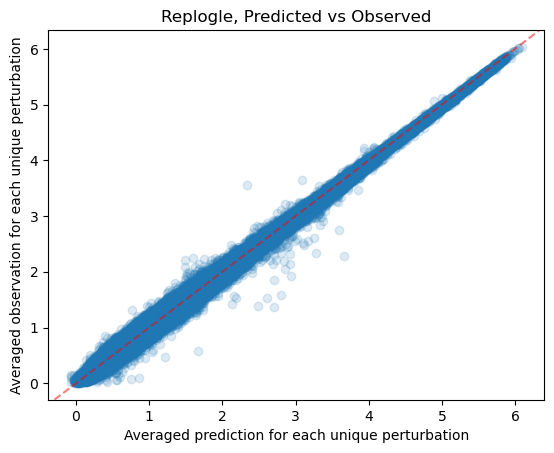

In [10]:
unique_pert = adata.obs.gene.unique()
avg_pred = np.zeros((len(unique_pert), adata.X.shape[1]))
avg_obs = np.zeros((len(unique_pert), adata.X.shape[1]))
for i, pert in enumerate(list(unique_pert)):
    if i%100 == 0:
        print(i)
    my_id = pert == adata.obs.gene
    predicted_mu_mean, predicted_mu_var, predicted_gamma_mean, predicted_gamma_var, \
        logit_p, logit_p_log_var, predicted_base_mean = parametric_model(my_conditioner[my_id],
                                                                         my_cell_info[my_id])
    estimated_base_mean = predicted_base_mean.detach().cpu().numpy()  
    estimated_perturbed_mean = (F.sigmoid(logit_p) * predicted_mu_mean).detach().cpu().numpy()
    avg_pred[i] = (estimated_perturbed_mean + estimated_base_mean).mean(0)
    avg_obs[i] = my_observation[my_id].mean(0).numpy()

fig, axes = plt.subplots(1, 1)
axes.scatter(avg_pred[avg_obs != 0], avg_obs[avg_obs != 0], alpha=0.15)
axes.axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes.set_xlabel('Averaged prediction for each unique perturbation')
axes.set_ylabel('Averaged observation for each unique perturbation')
axes.set_title('Replogle, Predicted vs Observed')

We now produce the estimated "activation map" for all annotated perturbations. Each cell corresponds to the estimated posterior inclusion probability of "the gene (column) is perturbed by the given perturbation (row)". A gene is included only if its posterior inclusion probability is greater than $95\%$ under at least one of the unique pertirbations. Only the top 200 genes are presented for sake of visual. Perturbations are grouped into distinct pathways.

In [11]:
threshold = 0.95
top=200
unique_conditions = torch.unique(my_conditioner, dim=0)
perturb_level, _, _, _, logit_p, _, _ = parametric_model(unique_conditions, None)
estimated_inclusion_prob = F.sigmoid(logit_p).detach().cpu().numpy()
estimated_inclusion = estimated_inclusion_prob > threshold
my_gene_name = np.array(gene_name)[estimated_inclusion.sum(axis=0) > 0]
estimated_inclusion_prob = estimated_inclusion_prob[:, estimated_inclusion.mean(axis=0) > 0]
estimated_pert = perturb_level.detach().cpu().numpy() * estimated_inclusion
estimated_pert = estimated_pert[:, estimated_inclusion.mean(axis=0) > 0]


unique_conditions = unique_conditions.numpy()
my_yticks = ['' for _ in range(unique_conditions.shape[0])]
ref_id = 0
for i in range(unique_conditions.shape[0]):
    if np.all(unique_conditions[i] == 0):
        my_yticks[i] = 'Non Targeting'
        ref_id = i
    else:
        my_yticks[i] = np.array(cond_name)[unique_conditions[i] == 1][0]

pathway_id = {}

for path in pathways:
    pathway_id[path] = [my_yticks.index(i) for i in pathways[path]]

my_yticks_reo = np.array(my_yticks)[np.concatenate(list(pathway_id.values()))]
estimated_pert_reo = estimated_pert[np.concatenate(list(pathway_id.values()))]
top_gene = np.argsort((estimated_pert**2).sum(axis=0))[::-1][:top]
estimated_pert_reo = estimated_pert_reo[:, top_gene]
my_gene_name_reo = my_gene_name[top_gene]
estimated_inclusion_prob_reo = estimated_inclusion_prob[np.concatenate(list(pathway_id.values()))]
estimated_inclusion_prob_reo = estimated_inclusion_prob_reo[:, top_gene]

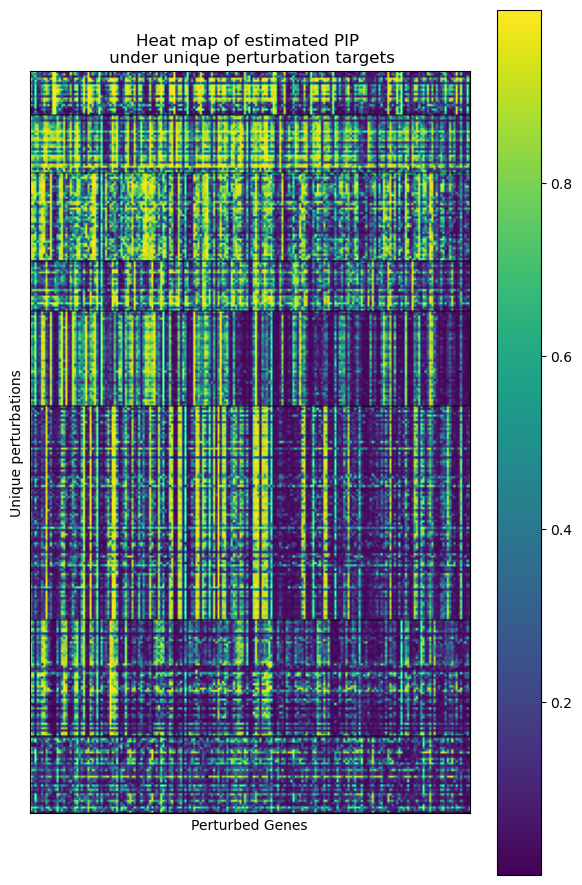

In [21]:
fig2, axes2 = plt.subplots(1, 1)

im = axes2.imshow(estimated_inclusion_prob_reo)
axes2.set_xticks([])
axes2.set_yticks([])
axes2.set_ylabel('')
for l in np.cumsum([len(i) for i in pathways.values()]):
    axes2.axline((0., l-0.5), slope=0, alpha=0.4, c='k')
axes2.set_xlabel('Perturbed Genes')
axes2.set_ylabel('Unique perturbations')
axes2.set_title('Heat map of estimated PIP \n under unique perturbation targets')
axes2.set_aspect('equal')
fig2.colorbar(im, ax=axes2)
fig2.set_size_inches(6, 9)
fig2.tight_layout()

We now produce the heatmap of estimated perturbed effects under all annotated perturbations. Similar to what we have reported in the paper, we only include the gene-perturbation pairs whose corresponding mean posterior inclusion probability is greater than $95\%$. Perturbations are grouped into distinct pathways.

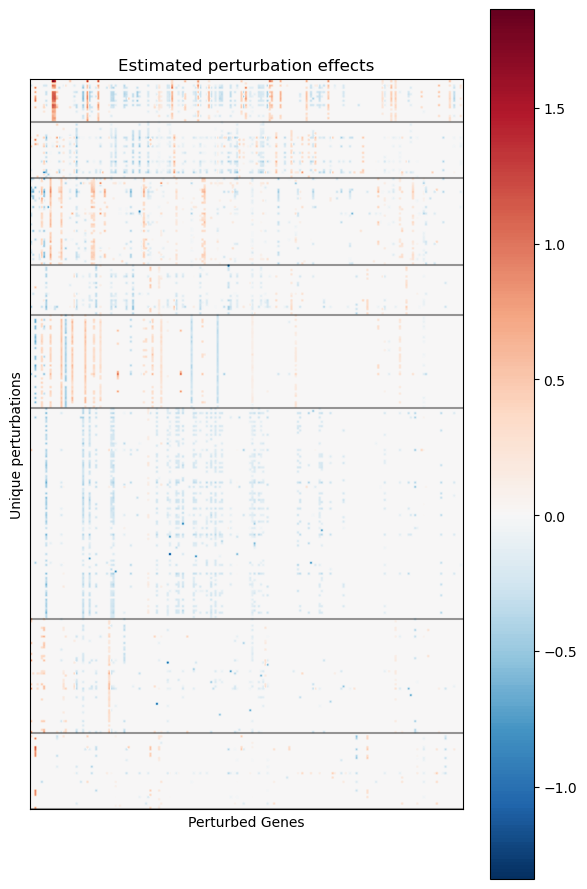

In [20]:
fig2, axes2 = plt.subplots(1, 1)
# plt.set_cmap('RdBu')
negatives = estimated_pert_reo.min()
positives = estimated_pert_reo.max()

num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
                   [cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)

im = axes2.imshow(estimated_pert_reo, cmap=cmap_2neg_4pos)
axes2.set_xticks([])
axes2.set_yticks([])
axes2.set_ylabel('')
for l in np.cumsum([len(i) for i in pathways.values()]):
    axes2.axline((0., l-0.5), slope=0, alpha=0.4, c='k')
axes2.set_xlabel('Perturbed Genes')
axes2.set_ylabel('Unique perturbations')
axes2.set_title('Estimated perturbation effects')
axes2.set_aspect('equal')
fig2.colorbar(im, ax=axes2)
fig2.set_size_inches(6, 9)
fig2.tight_layout()

We can group the unique perturbations according to their annotated pathways by projecting their estimated perturbation effects onto 2D plane using UMAP.

C:\Users\86304\AppData\Local\anaconda3\envs\work_env\Lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\86304\AppData\Local\anaconda3\envs\work_env\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


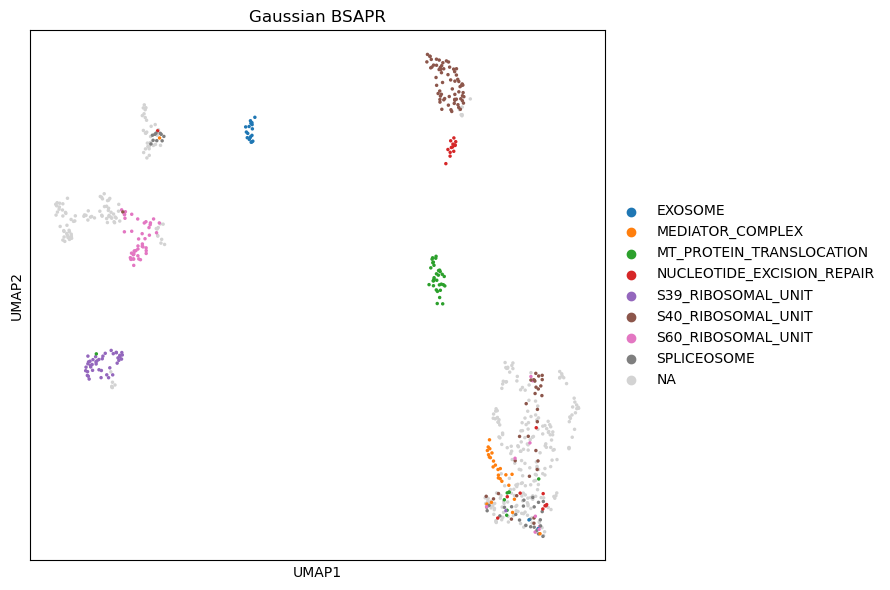

In [16]:
my_pathway = [None for _ in range(unique_conditions.shape[0])]
for i, name in enumerate(my_yticks):
    for j in pathways:
        if name in pathways[j]:
            my_pathway[i] = j

adata_BSAPR = AnnData(obs = pd.DataFrame(my_pathway, columns=['pathway']), X = estimated_pert[:, top_gene])

fig, ax = plt.subplots(1, 1)

sc.pp.pca(adata_BSAPR, n_comps=top-1)
sc.pp.neighbors(adata_BSAPR, n_neighbors=10)
sc.tl.umap(adata_BSAPR)
sc.pl.umap(adata_BSAPR, color=['pathway'], s=25, title='Gaussian BSAPR', ax=ax, show=False)

fig.set_size_inches(9,6)
fig.tight_layout()

# Zero-inflated Poisson BSAPR

In [22]:
# load the dataset
adata = sc.read_h5ad('replogle.h5ad')
adata.obs['n_feature'] = (adata.X > 0).sum(1)

# raw counting data X
my_observation = adata.X
gene_name = list(adata.var.gene_name)
my_observation = torch.tensor(my_observation * 1.0, dtype=torch.float)

# cell level information K
my_cell_info = adata.obs[['core_adjusted_UMI_count', 'mitopercent', 'n_feature', 'core_scale_factor']]
my_cell_info = torch.tensor(my_cell_info.to_numpy() * 1.0, dtype=torch.float)
my_cell_info[:, 2] = my_cell_info[:, 2] / my_cell_info[:, 0]
my_cell_info[:, 0] = np.log(my_cell_info[:, 0])

# annodated pathways
pathways = adata.uns['pathways']

# perturbation matrix C
my_conditioner = pd.get_dummies(adata.obs['gene'])
my_conditioner = my_conditioner.drop('non-targeting', axis=1)
cond_name = list(my_conditioner.columns)
my_conditioner = torch.tensor(my_conditioner.to_numpy() * 1.0, dtype=torch.float)


Training the model.

In [ ]:
# design the training process:
start = time.time()
output_dim = my_observation.shape[1]
sample_size = my_observation.shape[0]
hidden_node = 1000
hidden_layer_1 = 4
hidden_layer_2 = 4
conditioner_dim = my_conditioner.shape[1]
cell_info_dim = my_cell_info.shape[1]
tau = torch.tensor(1.).to(device)

parametric_model = BSAPR_ZIP(conditioner_dim=conditioner_dim, output_dim=output_dim,
                             base_dim=cell_info_dim, data_size=sample_size,
                             hidden_node=hidden_node, hidden_layer_1=hidden_layer_1,
                             hidden_layer_2=hidden_layer_2, tau=tau)
parametric_model = parametric_model.to(device)

parametric_model.BSAPR_train(epoch=300, observation=my_observation, cell_info=my_cell_info, perturbation=my_conditioner,
                             nu_1=5.0, nu_2=0.1, nu_3=1.0, nu_4=0.1, lr=5e-4, device=device)

In [25]:
parametric_model = BSAPR_ZIP(conditioner_dim=conditioner_dim, output_dim=output_dim,
                             base_dim=cell_info_dim, data_size=sample_size,
                             hidden_node=hidden_node, hidden_layer_1=hidden_layer_1,
                             hidden_layer_2=hidden_layer_2, tau=tau)
parametric_model.load_state_dict(torch.load('BSAPR_reo_ZIP_ref.pt'))

<All keys matched successfully>

One can obtain estimated Poisson rates and sparse perturbation effects using similar function calls.

In [14]:
predicted_mu_mean, _, predicted_base_mean, logit_p, _ = parametric_model(my_conditioner[parametric_model.test_id].to(device), my_cell_info[parametric_model.test_id].to(device))
estimated_perturbed_mean = (F.sigmoid(logit_p) * predicted_mu_mean)
estimated_inclusion_prob = F.sigmoid(logit_p).detach().cpu().numpy()
estimated_perturbed_mean = logexpp1(estimated_perturbed_mean + predicted_base_mean).detach().cpu().numpy()

Visualising averaged prediction vs averaged observations.

0
100
200
300
400
500
600


Text(0.5, 1.0, 'Replogle, Predicted vs Observed, Poisson')

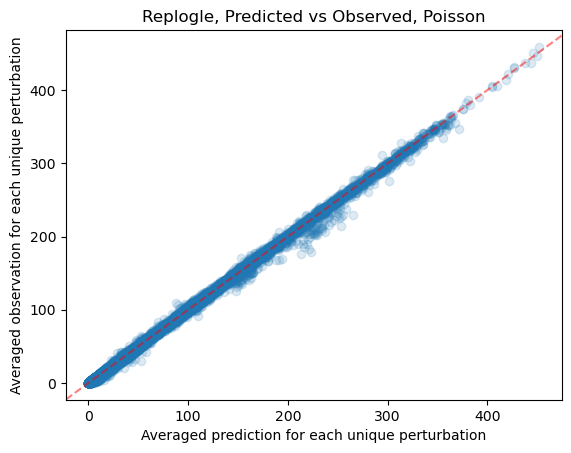

In [26]:
avg_pred = np.zeros((len(unique_pert), adata.X.shape[1]))
avg_obs = np.zeros((len(unique_pert), adata.X.shape[1]))
for i, pert in enumerate(list(unique_pert)):
    if i%100 == 0:
        print(i)
    my_id = pert == adata.obs.gene
    predicted_mu_mean, predicted_mu_var, predicted_base_mean, logit_p, logit_p_log_var = parametric_model(my_conditioner[my_id], my_cell_info[my_id])
    estimated_base_mean = predicted_base_mean  # * zeros[testing_idx].numpy()
    estimated_perturbed_mean = (F.sigmoid(logit_p) * predicted_mu_mean)
    avg_pred[i] = logexpp1(estimated_perturbed_mean + estimated_base_mean).detach().cpu().numpy().mean(0)
    avg_obs[i] = my_observation[my_id].mean(0).numpy()

fig, axes = plt.subplots(1, 1)
axes.scatter(avg_pred[avg_obs != 0], avg_obs[avg_obs != 0], alpha=0.15)
axes.axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes.set_xlabel('Averaged prediction for each unique perturbation')
axes.set_ylabel('Averaged observation for each unique perturbation')
axes.set_title('Replogle, Predicted vs Observed, Poisson')

We now generate the estimated "activation map" and heat map for perturbation effects in a similar fashion to the Gaussian case.

In [27]:
threshold = 0.95
top=200
unique_conditions = torch.unique(my_conditioner, dim=0)
perturb_level, _, _, logit_p, _ = parametric_model(unique_conditions, None)
estimated_inclusion_prob = F.sigmoid(logit_p).detach().cpu().numpy()
estimated_inclusion = estimated_inclusion_prob > threshold
my_gene_name = np.array(gene_name)[estimated_inclusion.sum(axis=0) > 0]
estimated_inclusion_prob = estimated_inclusion_prob[:, estimated_inclusion.mean(axis=0) > 0]
estimated_pert = perturb_level.detach().cpu().numpy() * estimated_inclusion
estimated_pert = estimated_pert[:, estimated_inclusion.mean(axis=0) > 0]

unique_conditions = unique_conditions.numpy()
my_yticks = ['' for _ in range(unique_conditions.shape[0])]
ref_id = 0
for i in range(unique_conditions.shape[0]):
    if np.all(unique_conditions[i] == 0):
        my_yticks[i] = 'Non Targeting'
        ref_id = i
    else:
        my_yticks[i] = np.array(cond_name)[unique_conditions[i] == 1][0]
        
pathway_id = {}
for path in pathways:
    pathway_id[path] = [my_yticks.index(i) for i in pathways[path]]

my_yticks_reo = np.array(my_yticks)[np.concatenate(list(pathway_id.values()))]
estimated_pert_reo = estimated_pert[np.concatenate(list(pathway_id.values()))]
top_gene = np.argsort((estimated_pert**2).sum(axis=0))[::-1][:top]
estimated_pert_reo = estimated_pert_reo[:, top_gene]
my_gene_name_reo = my_gene_name[top_gene]
estimated_inclusion_prob_reo = estimated_inclusion_prob[np.concatenate(list(pathway_id.values()))]
estimated_inclusion_prob_reo = estimated_inclusion_prob_reo[:, top_gene]

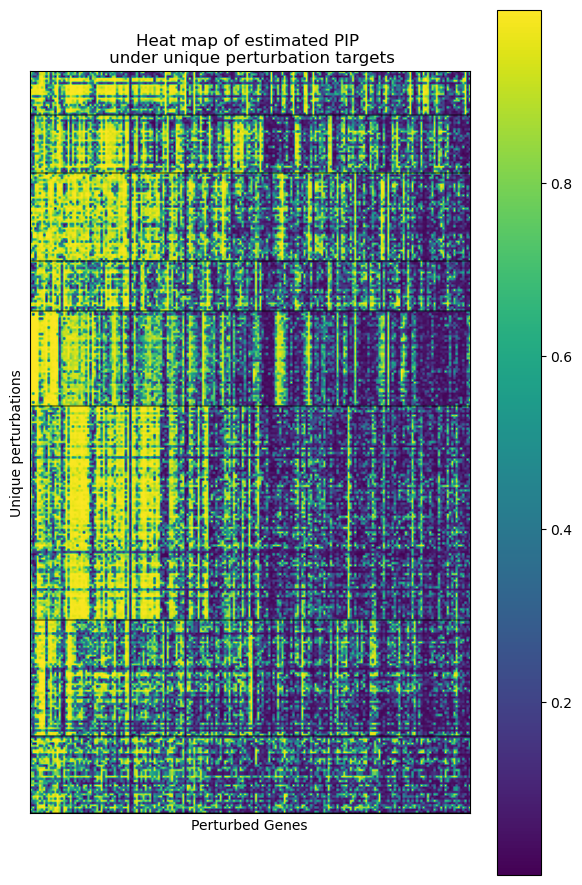

In [28]:
fig2, axes2 = plt.subplots(1, 1)

im = axes2.imshow(estimated_inclusion_prob_reo)
axes2.set_xticks([])
axes2.set_yticks([])
axes2.set_ylabel('')
for l in np.cumsum([len(i) for i in pathways.values()]):
    axes2.axline((0., l-0.5), slope=0, alpha=0.4, c='k')
axes2.set_xlabel('Perturbed Genes')
axes2.set_ylabel('Unique perturbations')
axes2.set_title('Heat map of estimated PIP \n under unique perturbation targets')
axes2.set_aspect('equal')
fig2.colorbar(im, ax=axes2)
fig2.set_size_inches(6, 9)
fig2.tight_layout()

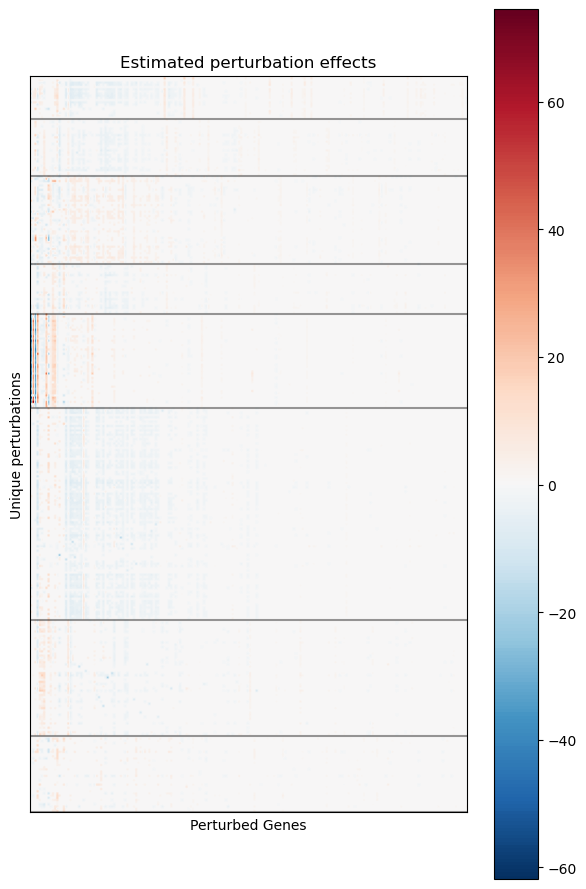

In [29]:
fig2, axes2 = plt.subplots(1, 1)
# plt.set_cmap('RdBu')
negatives = estimated_pert_reo.min()
positives = estimated_pert_reo.max()

num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
                   [cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)

im = axes2.imshow(estimated_pert_reo, cmap=cmap_2neg_4pos)
axes2.set_xticks([])
axes2.set_yticks([])
axes2.set_ylabel('')
for l in np.cumsum([len(i) for i in pathways.values()]):
    axes2.axline((0., l-0.5), slope=0, alpha=0.4, c='k')
axes2.set_xlabel('Perturbed Genes')
axes2.set_ylabel('Unique perturbations')
axes2.set_title('Estimated perturbation effects')
axes2.set_aspect('equal')
fig2.colorbar(im, ax=axes2)
fig2.set_size_inches(6, 9)
fig2.tight_layout()

Projecting the perturbation effects estimated by Poisson BSAPR onto 2D plane using UMAP.

C:\Users\86304\AppData\Local\anaconda3\envs\work_env\Lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\86304\AppData\Local\anaconda3\envs\work_env\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


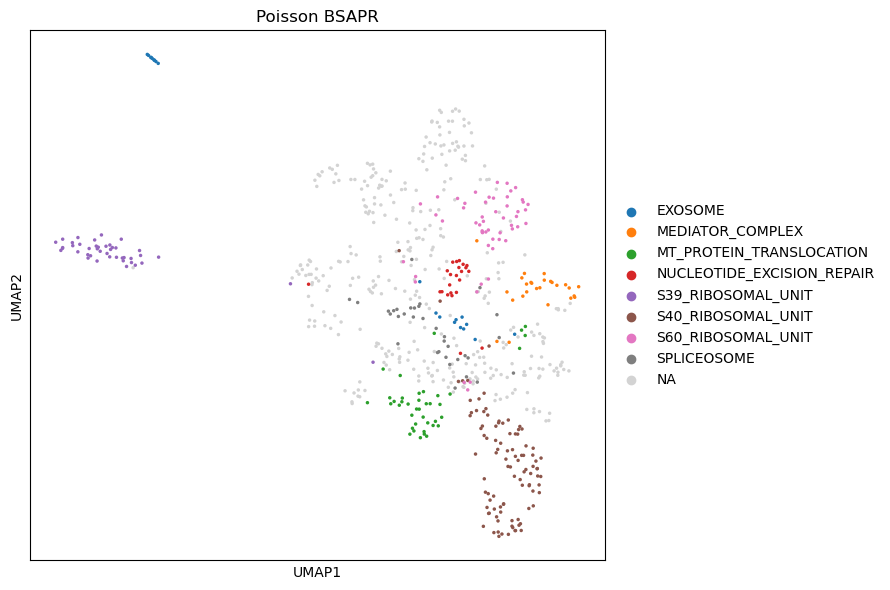

In [30]:
my_pathway = [None for _ in range(unique_conditions.shape[0])]
for i, name in enumerate(my_yticks):
    for j in pathways:
        if name in pathways[j]:
            my_pathway[i] = j
            
adata_BSAPR =AnnData(obs = pd.DataFrame(my_pathway, columns=['pathway']), X = estimated_pert[:, top_gene])
fig, ax = plt.subplots(1, 1)

sc.pp.pca(adata_BSAPR, n_comps=top-1)
sc.pp.neighbors(adata_BSAPR, n_neighbors=10)
sc.tl.umap(adata_BSAPR)
sc.pl.umap(adata_BSAPR, color=['pathway'], s=25, title='Poisson BSAPR', ax=ax, show=False)

fig.set_size_inches(9,6)
fig.tight_layout()